# Text mining project
## Group 12

In [58]:
import nltk
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords, movie_reviews
from nltk.corpus.reader import ConllCorpusReader
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from sklearn.datasets import load_files
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import KeyedVectors, LdaMulticore

stop_words = list(set(nltk.word_tokenize(' '.join(stopwords.words('english'))) + stopwords.words('english')))

## Loading and wrangling data

In [2]:
#loading in the test data provided
ner_test = pd.read_csv('data/NER-final-test.tsv', delimiter='\t')[['token', 'BIO NER tag']]
ner_test[['token', 'pos']] = nltk.pos_tag(ner_test['token'])

st_test = pd.read_csv('data/sentiment-topic-final-test.tsv', delimiter='\t').drop(columns=['sentence id'])

In [3]:
#use if you want to download the movie reviews corpus
# nltk.download('movie_reviews')

In [4]:
#loading in the ner from lab 4 and the airline tweets from lab 2
#we have 3 tasks, ner (Conll), sentiment analysis (airlinetweets) and topic classification (movie reviews, book reviews, restaurant reviews)

ner_train = pd.DataFrame(
    ConllCorpusReader('../Ass3/nerc_datasets/CONLL2003',
                      'train.txt', ['words', 'pos', 'ignore', 'chunk']
                     ).iob_words(), columns=['token', 'pos', 'label'])
ner_val = pd.DataFrame(
    ConllCorpusReader('../Ass3/nerc_datasets/CONLL2003',
                      'valid.txt', ['words', 'pos', 'ignore', 'chunk']
                     ).iob_words(), columns=['token', 'pos', 'label'])

sa_train = load_files('../Ass2/airlinetweets')

restaurants = pd.read_csv('data/Restaurant_Reviews.tsv', delimiter='\t').drop(columns=['Liked']).rename(columns={'Review': 'text'})
books = pd.read_csv('data/Book-reviews.csv', encoding='cp1252').rename(columns={'ReviewContent': 'text'})
movies = pd.DataFrame({'text': movie_reviews.sents()}).applymap(' '.join)

In [11]:
#transforming the ner data into a format that can be used by the DictVectorizer (bag of words)
v = DictVectorizer().fit([tok for l in [ner_train, ner_val, ner_test]
                          for tok in l[['token', 'pos']].T.to_dict().values()])

train = v.transform(ner_train[['token', 'pos']].T.to_dict().values())
val = v.transform(ner_val[['token', 'pos']].T.to_dict().values())

In [12]:
#transforming the sentiment analysis data into a format that can be used by the DictVectorizer (bag of words with tfidf)
vec = CountVectorizer(min_df=5, tokenizer=nltk.word_tokenize, stop_words=stop_words)
tfidf_transformer = TfidfTransformer()

counts = vec.fit_transform(sa_train.data + st_test.text.values.tolist())
tfidf = tfidf_transformer.fit_transform(counts)

tfidf, tfidf_test = tfidf[:-len(st_test.text.values)], tfidf[-len(st_test.text.values):]
tfidf_train, tfidf_val, tfidf_y_train, tfidf_y_val = train_test_split(tfidf, sa_train.target, test_size=0.2)

In [43]:
#transforming the topic classification data into a format that can be used by the DictVectorizer (bag of words with tfidf)
restaurants['topic'] = 'restaurant'
books['topic'] = 'book'
movies['topic'] = 'movie'
np.random.seed(0)

train_ta = pd.concat([restaurants, books, movies]).groupby('topic').sample(len(restaurants)).sample(frac=1)

vec = CountVectorizer(min_df=5, tokenizer=nltk.word_tokenize, stop_words=stop_words)
counts = vec.fit_transform(train_ta.text.values.tolist() + st_test.text.values.tolist())
tfidf_transformer = TfidfTransformer().fit(counts)

tfidf_ta = tfidf_transformer.transform(vec.transform(train_ta.text.values))

train_ta, val_ta, train_y_ta, val_y_ta = train_test_split(tfidf_ta, train_ta.topic, test_size=0.2)

In [44]:
val_ta.shape

(600, 1680)

## Training classification models for NERC with BoW

#### SVM hyperparameter tuning and training

In [14]:
# hyperparameter tuining the ner model using gridsearch to find the best parameters, repeating the process 5 times (cross validation), to confirm and compensate for randomness. 
# the result is {'C': 100.0} which is used in the final model. C is the inverse of the regularization strength, so a large C means a small regularization strength.

# svm = GridSearchCV(LinearSVC(), {'C': np.logspace(-2, 2, 5)}, scoring='f1_macro', n_jobs=-1)

# Takes forever to run so just use the params below
# svm.best_params_ = {'C': 100.0}

# svm_bow = LinearSVC(C=100, max_iter=10000)
# svm_bow.fit(train, ner_train['label'].values)

with open('models/NERC/BoW/svm.pkl', 'rb') as f:
    svm_bow = pickle.load(f)
svm_bow_pred = svm_bow.predict(val)
print(classification_report(ner_val['label'].values, svm_bow_pred))

              precision    recall  f1-score   support

       B-LOC       0.87      0.80      0.83      1837
      B-MISC       0.88      0.74      0.80       922
       B-ORG       0.80      0.65      0.72      1341
       B-PER       0.88      0.62      0.73      1842
       I-LOC       0.72      0.70      0.71       257
      I-MISC       0.79      0.51      0.62       346
       I-ORG       0.72      0.46      0.56       751
       I-PER       0.44      0.87      0.59      1307
           O       0.99      0.99      0.99     42759

    accuracy                           0.94     51362
   macro avg       0.79      0.70      0.73     51362
weighted avg       0.95      0.94      0.94     51362



#### Naive Bayes training

In [15]:
# does not have hyperparameters to tune, so just use the default parameters

# Naive Bayes doesn't make much sense for such a task but I wanted to have 3 classifiers and training a NN is a bit more of a hassle

# nb_bow = MultinomialNB()
# nb_bow.fit(train, ner_train['label'].values)

with open('models/NERC/BoW/nb.pkl', 'rb') as f:
    nb_bow = pickle.load(f)
nb_bow_pred = nb_bow.predict(val)
print(classification_report(ner_val['label'].values, nb_bow_pred))

              precision    recall  f1-score   support

       B-LOC       0.43      0.87      0.58      1837
      B-MISC       0.90      0.64      0.75       922
       B-ORG       0.70      0.54      0.61      1341
       B-PER       0.81      0.62      0.70      1842
       I-LOC       0.85      0.11      0.20       257
      I-MISC       0.93      0.15      0.26       346
       I-ORG       0.60      0.42      0.50       751
       I-PER       0.73      0.35      0.48      1307
           O       0.98      0.99      0.99     42759

    accuracy                           0.92     51362
   macro avg       0.77      0.52      0.56     51362
weighted avg       0.93      0.92      0.92     51362



#### KNN hyperparameter tuning and training

In [16]:
# hyperparameter tuining the ner model using gridsearch to find the best parameters, repeating the process 5 times (cross validation), to confirm and compensate for randomness.

# knn = GridSearchCV(KNeighborsClassifier(),
#                    {'n_neighbors': np.arange(2, 14, 2), 'p': [1, 2, 3]},
#                    scoring='f1_macro',
#                    n_jobs=-1)

# Takes forever to run so just use the params below
# knn.best_params_ = {'n_neighbors': 12, 'p': 1}

# knn_bow = KNeighborsClassifier(n_neighbors=12, p=1, n_jobs=-1)
# knn_bow.fit(train, ner_train['label'].values)

with open('models/NERC/BoW/knn.pkl', 'rb') as f:
    knn_bow = pickle.load(f)
knn_bow_pred = knn_bow.predict(val)
print(classification_report(ner_val['label'].values, knn_bow_pred))

              precision    recall  f1-score   support

       B-LOC       0.82      0.70      0.76      1837
      B-MISC       0.80      0.63      0.71       922
       B-ORG       0.23      0.71      0.35      1341
       B-PER       0.86      0.37      0.52      1842
       I-LOC       0.70      0.59      0.64       257
      I-MISC       0.82      0.38      0.52       346
       I-ORG       0.76      0.32      0.45       751
       I-PER       0.64      0.14      0.23      1307
           O       0.98      0.99      0.99     42759

    accuracy                           0.91     51362
   macro avg       0.74      0.54      0.57     51362
weighted avg       0.93      0.91      0.91     51362



## Training classification models for NERC with word embeddings

In [17]:
word_embedding_model = KeyedVectors.load_word2vec_format('../../GoogleNews-vectors-negative300.bin', binary=True)

def to_embedding(word):
    if word != '' and word != 'DOCSTART' and word in word_embedding_model:
        return word_embedding_model[word]
    return [0]*300

In [18]:
train = np.concatenate(ner_train['token'].map(to_embedding).values).reshape(-1, 300)
val = np.concatenate(ner_val['token'].map(to_embedding).values).reshape(-1, 300)

#### SVM hyperparameter tuning and training

In [19]:
# svm_we = GridSearchCV(LinearSVC(), {'C': np.logspace(-2, 2, 5)}, scoring='f1_macro', n_jobs=-1)

# Takes forever to run so just use the params below
# svm.best_params_ = {'C': 10.0}

# svm_we = LinearSVC(C=10, max_iter=10000)
# svm_we.fit(train, ner_train['label'].values)

with open('models/NERC/Embedding/svm.pkl', 'rb') as f:
    svm_we = pickle.load(f)
svm_we_pred = svm_we.predict(val)
print(classification_report(ner_val['label'].values, svm_we_pred))

              precision    recall  f1-score   support

       B-LOC       0.82      0.80      0.81      1837
      B-MISC       0.78      0.69      0.74       922
       B-ORG       0.70      0.64      0.67      1341
       B-PER       0.78      0.71      0.75      1842
       I-LOC       0.61      0.56      0.58       257
      I-MISC       0.68      0.43      0.53       346
       I-ORG       0.61      0.36      0.45       751
       I-PER       0.60      0.57      0.58      1307
           O       0.97      1.00      0.98     42759

    accuracy                           0.94     51362
   macro avg       0.73      0.64      0.68     51362
weighted avg       0.93      0.94      0.93     51362



#### KNN training

In [20]:
# knn_we = KNeighborsClassifier() # Too inefficient to run grid search
# knn_we.fit(train, ner_train['label'].values)

with open('models/NERC/Embedding/knn.pkl', 'rb') as f:
    knn_we = pickle.load(f)
knn_we_pred = knn_we.predict(val)
print(classification_report(ner_val['label'].values, knn_we_pred))

              precision    recall  f1-score   support

       B-LOC       0.80      0.83      0.81      1837
      B-MISC       0.77      0.72      0.74       922
       B-ORG       0.69      0.65      0.67      1341
       B-PER       0.74      0.70      0.72      1842
       I-LOC       0.68      0.52      0.59       257
      I-MISC       0.74      0.46      0.57       346
       I-ORG       0.62      0.43      0.51       751
       I-PER       0.55      0.57      0.56      1307
           O       0.98      0.99      0.99     42759

    accuracy                           0.94     51362
   macro avg       0.73      0.65      0.68     51362
weighted avg       0.93      0.94      0.93     51362



#### Random Forest hyperparameter tuning and training

In [21]:
# rf_we = GridSearchCV(RandomForestClassifier(),
#                      {'n_estimators': np.arange(50, 151, 25), 'max_depth': [5, 10, 15, None]},
#                      scoring='f1_macro',
#                      n_jobs=-1)

# Takes forever to run so just use the params below
# rf_we.best_params = {'max_depth': None, 'n_estimators': 50}

# rf_we = RandomForestClassifier(n_estimators=50, max_depth=None)
# rf_we.fit(train, ner_train['label'].values)

with open('models/NERC/Embedding/rf.pkl', 'rb') as f:
    rf_we = pickle.load(f)
rf_we_pred = knn_we.predict(val)
print(classification_report(ner_val['label'].values, rf_we_pred))

              precision    recall  f1-score   support

       B-LOC       0.80      0.83      0.81      1837
      B-MISC       0.77      0.72      0.74       922
       B-ORG       0.69      0.65      0.67      1341
       B-PER       0.74      0.70      0.72      1842
       I-LOC       0.68      0.52      0.59       257
      I-MISC       0.74      0.46      0.57       346
       I-ORG       0.62      0.43      0.51       751
       I-PER       0.55      0.57      0.56      1307
           O       0.98      0.99      0.99     42759

    accuracy                           0.94     51362
   macro avg       0.73      0.65      0.68     51362
weighted avg       0.93      0.94      0.93     51362



## Plots

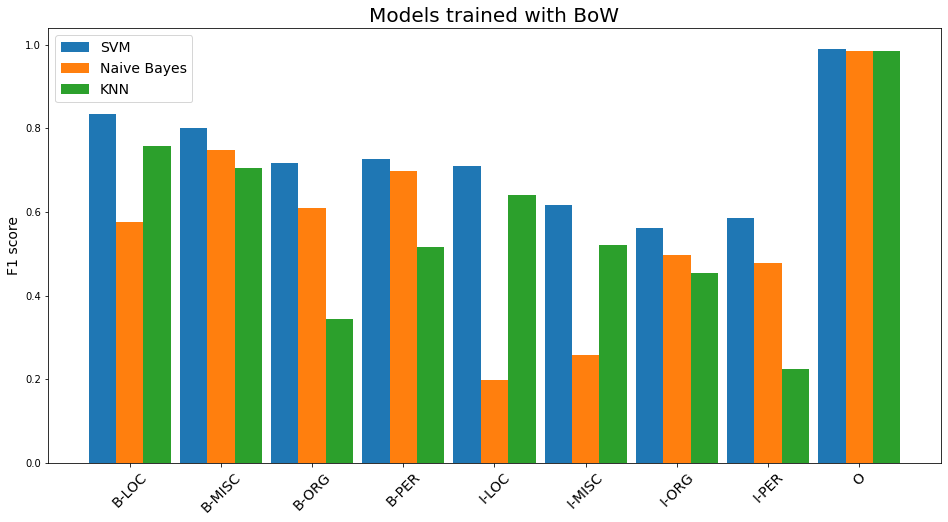

In [22]:
x = np.arange(0, 9)
plt.figure(figsize=(16, 8))
plt.bar(x - 0.3, height=f1_score(ner_val['label'], svm_bow_pred, average=None), width=0.3, label='SVM')
plt.bar(x, height=f1_score(ner_val['label'], nb_bow_pred, average=None), width=0.3, label='Naive Bayes')
plt.bar(x + 0.3, height=f1_score(ner_val['label'], knn_bow_pred, average=None), width=0.3, label='KNN')
plt.title('Models trained with BoW', fontsize=20)
plt.xticks(x, labels=sorted(ner_train.label.unique()), rotation=45, fontsize=14)
plt.ylabel('F1 score', fontsize=14)
plt.legend(fontsize=14)
plt.savefig('Plots/BoW models.png')
plt.show()

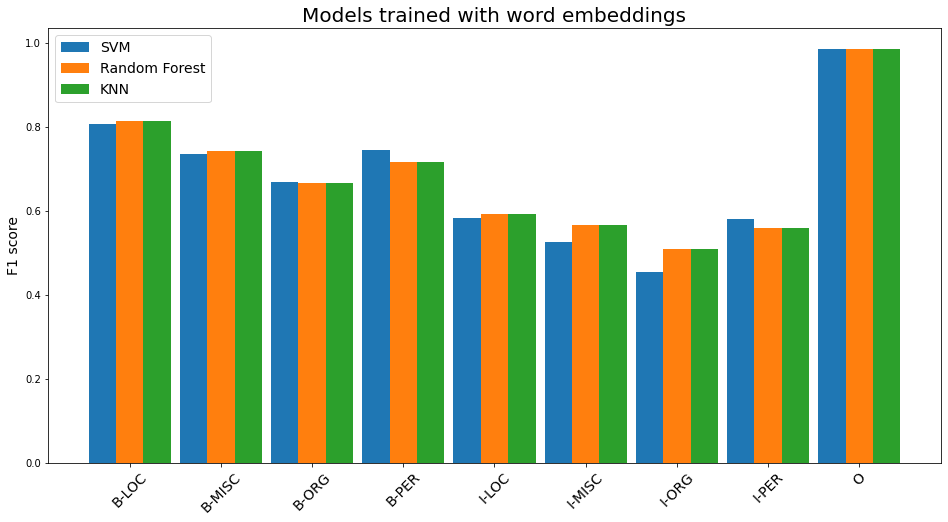

In [23]:
plt.figure(figsize=(16, 8))
plt.bar(x - 0.3, height=f1_score(ner_val['label'], svm_we_pred, average=None), width=0.3, label='SVM')
plt.bar(x, height=f1_score(ner_val['label'], rf_we_pred, average=None), width=0.3, label='Random Forest')
plt.bar(x + 0.3, height=f1_score(ner_val['label'], knn_we_pred, average=None), width=0.3, label='KNN')
plt.title('Models trained with word embeddings', fontsize=20)
plt.xticks(x, labels=sorted(ner_train.label.unique()), rotation=45, fontsize=14)
plt.ylabel('F1 score', fontsize=14)
plt.legend(fontsize=14)
plt.savefig('Plots/WE models.png')
plt.show()

### The best model
Is an SVM trained with a bag of words representation.

In [24]:
print(classification_report(ner_test['BIO NER tag'], svm_bow.predict(v.transform(ner_test[['token', 'pos']].T.to_dict().values())), zero_division=0))

              precision    recall  f1-score   support

       B-LOC       0.50      0.50      0.50         4
      B-MISC       0.75      1.00      0.86         3
       B-ORG       0.00      0.00      0.00         4
       B-PER       0.75      0.50      0.60         6
       I-LOC       0.67      1.00      0.80         2
      I-MISC       0.00      0.00      0.00         1
       I-ORG       0.50      0.67      0.57         3
       I-PER       0.64      0.88      0.74         8
           O       0.99      1.00      1.00       183

    accuracy                           0.94       214
   macro avg       0.53      0.62      0.56       214
weighted avg       0.93      0.94      0.93       214



## Sentiment analysis and classification

### Using VADER

In [25]:
def vader_output_to_label(vader_output):
    compound = vader_output['compound']
    if compound < 0:
        return 'negative'
    elif compound == 0.0:
        return 'neutral'
    return 'positive'

vader_model = SentimentIntensityAnalyzer()

In [26]:
vader_pred = [vader_output_to_label(vader_model.polarity_scores(text)) for text in st_test.text.values]
print(classification_report(st_test.sentiment.values, vader_pred, target_names=sa_train.target_names))

              precision    recall  f1-score   support

    negative       1.00      0.33      0.50         3
     neutral       1.00      0.33      0.50         3
    positive       0.50      1.00      0.67         4

    accuracy                           0.60        10
   macro avg       0.83      0.56      0.56        10
weighted avg       0.80      0.60      0.57        10



### Using conventional models

#### SVM hyperparameter tuning and training

In [27]:
# svm_sa = GridSearchCV(LinearSVC(), {'C': np.logspace(-2, 2, 5)}, scoring='f1_macro', n_jobs=-1)

with open('models/Sentiment/svm.pkl', 'rb') as f:
    svm_sa = pickle.load(f)
svm_sa.fit(tfidf_train, tfidf_y_train)
svm_sa_pred = svm_sa.predict(tfidf_val)
print(classification_report(tfidf_y_val, svm_sa_pred, target_names=sa_train.target_names))

              precision    recall  f1-score   support

    negative       0.84      0.85      0.84       367
     neutral       0.75      0.73      0.74       299
    positive       0.82      0.82      0.82       285

    accuracy                           0.81       951
   macro avg       0.80      0.80      0.80       951
weighted avg       0.81      0.81      0.81       951



#### Naive Bayes training

In [49]:
# nb_sa = MultinomialNB()
# nb_sa.fit(tfidf_train, tfidf_y_train)

with open('models/Sentiment/nb.pkl', 'rb') as f:
    nb_sa = pickle.load(f)
nb_sa_pred = nb_sa.predict(tfidf_val)
print(classification_report(tfidf_y_val, nb_sa_pred, target_names=sa_train.target_names))

              precision    recall  f1-score   support

    negative       0.86      0.91      0.88       367
     neutral       0.84      0.77      0.81       299
    positive       0.86      0.88      0.87       285

    accuracy                           0.86       951
   macro avg       0.86      0.85      0.85       951
weighted avg       0.86      0.86      0.86       951



### Naive Bayes
Is best for sentiment analysis. The bad results are because of a different dsitribution than the one trained on.

In [50]:
print(classification_report(st_test.sentiment, [sa_train.target_names[i] for i in nb_sa.predict(tfidf_test)]))

              precision    recall  f1-score   support

    negative       0.40      0.67      0.50         3
     neutral       0.50      0.33      0.40         3
    positive       0.33      0.25      0.29         4

    accuracy                           0.40        10
   macro avg       0.41      0.42      0.40        10
weighted avg       0.40      0.40      0.38        10



## Topic analysis and classification

### Using conventional models

#### SVM hyperparameter tuning and training

In [51]:
# svm_ta = GridSearchCV(LinearSVC(), {'C': np.logspace(-2, 2, 5)}, scoring='f1_macro', n_jobs=-1)
# svm_ta.fit(train_ta, train_y_ta)

# with open('models/Topic/svm.pkl', 'wb') as f:
#     pickle.dump(svm_ta.best_estimator_, f)

with open('models/Topic/svm.pkl', 'rb') as f:
    svm_ta = pickle.load(f)
svm_ta_pred = svm_ta.predict(val_ta)
print(classification_report(val_y_ta, svm_ta_pred))

              precision    recall  f1-score   support

        book       0.99      0.97      0.98       202
       movie       0.94      0.88      0.91       203
  restaurant       0.87      0.95      0.91       195

    accuracy                           0.93       600
   macro avg       0.94      0.93      0.93       600
weighted avg       0.94      0.93      0.93       600



#### Naive Bayes training

In [52]:
# nb_ta = MultinomialNB()
# nb_ta.fit(train_ta, train_y_ta)

# with open('models/Topic/nb.pkl', 'wb') as f:
#     pickle.dump(nb_ta, f)

with open('models/Topic/nb.pkl', 'rb') as f:
    nb_ta = pickle.load(f)
nb_ta_pred = nb_ta.predict(val_ta)
print(classification_report(val_y_ta, nb_ta_pred))

              precision    recall  f1-score   support

        book       0.87      0.99      0.92       202
       movie       0.92      0.84      0.88       203
  restaurant       0.93      0.88      0.91       195

    accuracy                           0.90       600
   macro avg       0.91      0.90      0.90       600
weighted avg       0.91      0.90      0.90       600



### SVM
slightly outperforms naive bayes in topic classification.

In [53]:
print(classification_report(st_test.topic, svm_ta.predict(tfidf_transformer.transform(vec.transform(st_test.text.values)))))

              precision    recall  f1-score   support

        book       1.00      1.00      1.00         2
       movie       1.00      1.00      1.00         5
  restaurant       1.00      1.00      1.00         3

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



### Using LDA

In [54]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\luked\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [55]:
lemmatizer = WordNetLemmatizer()
preprocess = lambda x: [lemmatizer.lemmatize(token) for token in simple_preprocess(x) if token not in STOPWORDS]
docs = pd.concat([restaurants, books, movies]).groupby('topic').sample(len(restaurants)).sample(frac=1).text.map(preprocess)
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=1, no_above=0.5, keep_n=100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in docs]

In [56]:
lda_ta = LdaMulticore(bow_corpus, num_topics=3, id2word=dictionary, passes=5, workers=2)

In [57]:
for idx, topic in lda_ta.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.021*"book" + 0.016*"character" + 0.010*"read" + 0.010*"like" + 0.010*"story" + 0.008*"rachel" + 0.007*"time" + 0.007*"movie" + 0.007*"good" + 0.006*"life"
Topic: 1 Word: 0.008*"train" + 0.007*"service" + 0.007*"good" + 0.007*"food" + 0.007*"rachel" + 0.007*"life" + 0.006*"film" + 0.006*"character" + 0.006*"girl" + 0.006*"woman"
Topic: 2 Word: 0.040*"book" + 0.022*"character" + 0.022*"read" + 0.016*"story" + 0.009*"good" + 0.009*"great" + 0.009*"like" + 0.008*"time" + 0.008*"end" + 0.008*"reading"


The topics deduced by LDA do not seem to conform to the three topics of movies, restaurants, and books and thus classification using this model would be futile.